# AI/ML Salary Prediction & Career Advisor

**UC Berkeley AI/ML Certification Capstone Project**  
**Author: Sumanth Borra**  
**Date: January 2026**

This notebook implements an uncertainty-aware salary predictor for AI/ML roles, using metadata and NLP features from merged Kaggle datasets.

For full project overview, setup, and findings, see [README.md](README.md).

##1. Imports and Setup

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
import shap
import gradio as gr
import warnings

warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)

print("Imports complete")

Imports complete


##2. Data Loading

Load CSVs from online Kaggle datasets folders. Then inspecting the datasets.

In [40]:
from google.colab import userdata
import json
import os

# Load the full JSON string from secret
kaggle_json_str = userdata.get('KAGGLE_API_TOKEN')

# Parse the JSON to get username and key
kaggle_creds = json.loads(kaggle_json_str)
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

print("Kaggle env vars set successfully")

# Test auth
!kaggle datasets list | head -n 5

Kaggle env vars set successfully
ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                             3491  2025-12-11 15:29:14.327000           2114        283  1.0              
suvidyasonawane/student-academic-placement-performance-dataset    Student Academic Placement Performance Dataset           94469  2026-01-11 02:02:47.837000              0         27  1.0              
neurocipher/student-performance                                   Student Performance                                      49705  2025-12-12 12:06:28.973000   

In [41]:
# List of datasets (add the new ones)
datasets = [
    ("asaniczka/data-science-job-postings-and-skills", "./ds_postings_skills"),
    ("adilshamim8/salaries-for-data-science-jobs", "./salaries_ds_jobs"),
    ("kanchana1990/ai-and-ml-job-listings-usa", "./ai_ml_usa"),
    ("bismasajjad/global-ai-job-market-and-salary-trends-2025", "./global_ai_2025"),
    ("ruchi798/data-science-job-salaries", "./ds_job_salaries"),
    ("saurabhbadole/latest-data-science-job-salaries-2024", "./latest_ds_2024")
]

# Download and unzip each one
for slug, path in datasets:
    print(f"\n=== Downloading {slug} ===")
    !mkdir -p {path}
    !kaggle datasets download -d {slug} -p {path}
    !unzip -o {path}/*.zip -d {path}

# Show files
print("\n=== Downloaded files overview ===")
!ls -la ./ds_postings_skills
!ls -la ./salaries_ds_jobs
!ls -la ./ai_ml_usa
!ls -la ./global_ai_2025
!ls -la ./ds_job_salaries  # New
!ls -la ./latest_ds_2024  # New


=== Downloading asaniczka/data-science-job-postings-and-skills ===
Dataset URL: https://www.kaggle.com/datasets/asaniczka/data-science-job-postings-and-skills
License(s): ODC Attribution License (ODC-By)
data-science-job-postings-and-skills.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./ds_postings_skills/data-science-job-postings-and-skills.zip
  inflating: ./ds_postings_skills/job_postings.csv  
  inflating: ./ds_postings_skills/job_skills.csv  
  inflating: ./ds_postings_skills/job_summary.csv  

=== Downloading adilshamim8/salaries-for-data-science-jobs ===
Dataset URL: https://www.kaggle.com/datasets/adilshamim8/salaries-for-data-science-jobs
License(s): DbCL-1.0
salaries-for-data-science-jobs.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./salaries_ds_jobs/salaries-for-data-science-jobs.zip
  inflating: ./salaries_ds_jobs/salaries.csv  
  inflating: ./salaries_ds_jobs/salaries.

In [42]:
# Inspect job_summary.csv
print("\n=== job_summary.csv (from asaniczka) ===")
df1_summary = pd.read_csv('./ds_postings_skills/job_summary.csv')
print("Rows:", df1_summary.shape[0])
print("Columns:", df1_summary.columns.tolist())
print("\nMissing values:\n", df1_summary.isnull().sum())
print("\nFirst 3 rows:")
display(df1_summary.head(3))
print("\nSample summary (first one, 500 chars):\n", df1_summary.get('summary', pd.Series()).str[:500].iloc[0] if 'summary' in df1_summary.columns else "No summary column")

# Inspect job_skills.csv
print("\n=== job_skills.csv (from asaniczka) ===")
df1_skills = pd.read_csv('./ds_postings_skills/job_skills.csv')
print("Rows:", df1_skills.shape[0])
print("Columns:", df1_skills.columns.tolist())
print("\nMissing values:\n", df1_skills.isnull().sum())
print("\nFirst 3 rows:")
display(df1_skills.head(3))
print("\nSample skills (first one):\n", df1_skills.get('skills', pd.Series()).iloc[0] if 'skills' in df1_skills.columns else "No skills column")


=== job_summary.csv (from asaniczka) ===
Rows: 12217
Columns: ['job_link', 'job_summary']

Missing values:
 job_link       0
job_summary    0
dtype: int64

First 3 rows:


,job_link,job_summary
0,https://www.linkedin.com/jobs/view/senior-mach...,Company Description\nJobs for Humanity is part...
1,https://www.linkedin.com/jobs/view/principal-s...,Who We Are\nAurora (Nasdaq: AUR) is delivering...
2,https://www.linkedin.com/jobs/view/senior-etl-...,"Location: New York City, NY\nPosition Summary\..."



Sample summary (first one, 500 chars):
 No summary column

=== job_skills.csv (from asaniczka) ===
Rows: 12217
Columns: ['job_link', 'job_skills']

Missing values:
 job_link      0
job_skills    5
dtype: int64

First 3 rows:


,job_link,job_skills
0,https://www.linkedin.com/jobs/view/senior-mach...,"Machine Learning, Programming, Python, Scala, ..."
1,https://www.linkedin.com/jobs/view/principal-s...,"C++, Python, PyTorch, TensorFlow, MXNet, CUDA,..."
2,https://www.linkedin.com/jobs/view/senior-etl-...,"ETL, Data Integration, Data Transformation, Da..."



Sample skills (first one):
 No skills column


Fix the load paths

In [43]:
# Load main CSVs from downloaded folders
df1_postings = pd.read_csv('./ds_postings_skills/job_postings.csv')
df1_summary = pd.read_csv('./ds_postings_skills/job_summary.csv')
df1_skills = pd.read_csv('./ds_postings_skills/job_skills.csv')

df2 = pd.read_csv('./salaries_ds_jobs/salaries.csv')

df3 = pd.read_csv('./ai_ml_usa/ai_ml_jobs_linkedin.csv')

df4 = pd.read_csv('./global_ai_2025/ai_job_dataset.csv')  # Or ai_job_dataset1.csv if preferred

# New loads
df5 = pd.read_csv('./ds_job_salaries/ds_salaries.csv')  # Adjust if different
df6 = pd.read_csv('./latest_ds_2024/DataScience_salaries_2025.csv')  # Fixed filename

print("Datasets loaded")
print("df1_postings shape:", df1_postings.shape)
print("df2 shape:", df2.shape)
print("df3 shape:", df3.shape)
print("df4 shape:", df4.shape)
print("df5 shape:", df5.shape)
print("df6 shape:", df6.shape)

Datasets loaded
df1_postings shape: (12217, 15)
df2 shape: (151445, 11)
df3 shape: (862, 10)
df4 shape: (15000, 19)
df5 shape: (607, 12)
df6 shape: (93597, 11)


##3. Data Preparation & Cleaning

Merge datasets, standardize columns, clean salary, deduplicate, fill missing values.

In [44]:
# Enrich df1_postings with summary and skills (merge on 'job_link')
df1_postings = df1_postings.merge(df1_summary[['job_link', 'job_summary']], on='job_link', how='left')
df1_postings = df1_postings.merge(df1_skills[['job_link', 'job_skills']], on='job_link', how='left')

# Expanded rename map to catch variations
column_rename_map = {
    'job_title': 'title',
    'job_level': 'experience_level',
    'job_type': 'employment_type',
    'job_location': 'location',
    'job_summary': 'description',  # Use summary as text
    'job_skills': 'skills',  # Comma-separated
    'employee_residence': 'residence',
    'company_location': 'location',
    'salary_usd': 'salary_in_usd',
    'companyName': 'company',
    'company_name': 'company',
    'experienceLevel': 'experience_level',
    'contractType': 'employment_type',
    'workType': 'remote_ratio'
}

df1_postings.rename(columns=column_rename_map, inplace=True)
df2.rename(columns=column_rename_map, inplace=True)
df3.rename(columns=column_rename_map, inplace=True)
df4.rename(columns=column_rename_map, inplace=True)
df5.rename(columns=column_rename_map, inplace=True)
df6.rename(columns=column_rename_map, inplace=True)

# Salary handling (numeric, drop NaN)
for df in [df2, df4, df5, df6]:
    df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')
    df.dropna(subset=['salary_in_usd'], inplace=True)

# Basic cleaning (drop duplicates within each)
for df in [df1_postings, df2, df3, df4, df5, df6]:
    available_subset = [col for col in ['title', 'company', 'location'] if col in df.columns]
    if available_subset:
        df.drop_duplicates(subset=available_subset, keep='first', inplace=True)

# Merge: Start with salary-rich concat of all salary dfs
merged = pd.concat([df2, df4, df5, df6], ignore_index=True)

# Left merge text/skills from description-rich dfs (df1, df3, df5, df6) - only existing keys/cols
available_keys = [col for col in ['title', 'company', 'location'] if col in merged.columns]
enrich_cols = ['description', 'skills', 'experience_level']

for enriching_df, suffix in [(df1_postings, '_df1'), (df3, '_df3'), (df5, '_df5'), (df6, '_df6')]:
    keys_in_df = [col for col in available_keys if col in enriching_df.columns]
    cols_in_df = [col for col in enrich_cols if col in enriching_df.columns]
    if keys_in_df:
        merged = merged.merge(enriching_df[keys_in_df + cols_in_df], on=keys_in_df, how='left', suffixes=('', suffix))

# Fill NaN descriptions/skills from other sources - conditional on column existence
for col in ['description', 'skills', 'experience_level']:
    suffix_cols = [c for c in merged.columns if c.startswith(col + '_df')]
    for suffix_col in suffix_cols:
        merged[col] = merged[col].fillna(merged[suffix_col])
    # Drop the suffix columns
    merged.drop(columns=suffix_cols, inplace=True)

# Final dedup (on available keys + salary)
available_dedup_subset = [col for col in ['title', 'company', 'location', 'salary_in_usd'] if col in merged.columns]
merged.drop_duplicates(subset=available_dedup_subset, keep='first', inplace=True)

# Handle missing: Fill categorical with 'Unknown', numeric with 0/median
merged.fillna({'experience_level': 'Unknown', 'employment_type': 'Unknown', 'remote_ratio': 0, 'company_size': 'Unknown', 'location': 'Unknown', 'residence': 'Unknown', 'description': '', 'skills': ''}, inplace=True)

print("Merged shape:", merged.shape)
print("Merged columns:", merged.columns.tolist())
display(merged.head(5))
print("\nMissing after fill:\n", merged.isnull().sum())

# Save processed
merged.to_csv('merged_ai_jobs.csv', index=False)

Merged shape: (8141, 24)
Merged columns: ['work_year', 'experience_level', 'employment_type', 'title', 'salary', 'salary_currency', 'salary_in_usd', 'residence', 'remote_ratio', 'location', 'company_size', 'job_id', 'required_skills', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'job_description_length', 'benefits_score', 'company', 'Unnamed: 0', 'description', 'skills']


,work_year,experience_level,employment_type,title,salary,salary_currency,salary_in_usd,residence,remote_ratio,location,...,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company,Unnamed: 0,description,skills
0,2025.0,EX,FT,Head of Data,348516.0,USD,348516,US,0,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
1,2025.0,SE,FT,Data Scientist,145400.0,USD,145400,US,0,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
2,2025.0,MI,FT,Engineer,160000.0,USD,160000,US,100,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
3,2025.0,SE,FT,AI Product Lead,175000.0,USD,175000,US,100,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
4,2025.0,SE,FT,AI Engineer,97900.0,USD,97900,US,100,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,



Missing after fill:
 work_year                 5780
experience_level             0
employment_type              0
title                        0
salary                    5780
salary_currency              0
salary_in_usd                0
residence                    0
remote_ratio                 0
location                     0
company_size                 0
job_id                    2361
required_skills           2361
education_required        2361
years_experience          2361
industry                  2361
posting_date              2361
application_deadline      2361
job_description_length    2361
benefits_score            2361
company                   2361
Unnamed: 0                8004
description                  0
skills                       0
dtype: int64


##3.5 Consolidate Duplicate Data

In [45]:
# Rename duplicate columns to unique names for consolidation (expanded to handle suffixes)
description_cols = [col for col in merged.columns if 'description' in col.lower() or 'job_summary' in col.lower()]
skills_cols = [col for col in merged.columns if 'skills' in col.lower() or 'job_skills' in col.lower()]

# Rename to unique
for i, col in enumerate(description_cols):
    merged.rename(columns={col: f'description_{i}'}, inplace=True)
for i, col in enumerate(skills_cols):
    merged.rename(columns={col: f'skills_{i}'}, inplace=True)

# Now consolidate description
desc_unique_cols = [col for col in merged.columns if 'description_' in col]
merged['description'] = merged[desc_unique_cols].apply(lambda row: '; '.join(row.dropna().astype(str).unique()), axis=1)
merged.drop(columns=desc_unique_cols, inplace=True)

# Consolidate skills
skills_unique_cols = [col for col in merged.columns if 'skills_' in col]
merged['skills'] = merged[skills_unique_cols].apply(lambda row: '; '.join(row.dropna().astype(str).unique()), axis=1)
merged.drop(columns=skills_unique_cols, inplace=True)

# Clean up experience_level if duplicated
exp_cols = [col for col in merged.columns if 'experience_level' in col.lower() or 'job_level' in col.lower()]
if len(exp_cols) > 1:
    merged['experience_level'] = merged[exp_cols].bfill(axis=1).iloc[:, 0]
    merged.drop(columns=[c for c in exp_cols if c != 'experience_level'], inplace=True)

print("Fully consolidated shape:", merged.shape)
print("Fully consolidated columns:", merged.columns.tolist())
display(merged.head(5))
print("\nMissing after consolidation:\n", merged.isnull().sum())

merged.to_csv('merged_ai_jobs.csv', index=False)

Fully consolidated shape: (8141, 22)
Fully consolidated columns: ['work_year', 'experience_level', 'employment_type', 'title', 'salary', 'salary_currency', 'salary_in_usd', 'residence', 'remote_ratio', 'location', 'company_size', 'job_id', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'benefits_score', 'company', 'Unnamed: 0', 'description', 'skills']


,work_year,experience_level,employment_type,title,salary,salary_currency,salary_in_usd,residence,remote_ratio,location,...,education_required,years_experience,industry,posting_date,application_deadline,benefits_score,company,Unnamed: 0,description,skills
0,2025.0,EX,FT,Head of Data,348516.0,USD,348516,US,0,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
1,2025.0,SE,FT,Data Scientist,145400.0,USD,145400,US,0,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
2,2025.0,MI,FT,Engineer,160000.0,USD,160000,US,100,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
3,2025.0,SE,FT,AI Product Lead,175000.0,USD,175000,US,100,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
4,2025.0,SE,FT,AI Engineer,97900.0,USD,97900,US,100,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,



Missing after consolidation:
 work_year               5780
experience_level           0
employment_type            0
title                      0
salary                  5780
salary_currency            0
salary_in_usd              0
residence                  0
remote_ratio               0
location                   0
company_size               0
job_id                  2361
education_required      2361
years_experience        2361
industry                2361
posting_date            2361
application_deadline    2361
benefits_score          2361
company                 2361
Unnamed: 0              8004
description                0
skills                     0
dtype: int64


In [46]:
print("Non-empty descriptions:", merged['description'].str.strip().ne('').sum())
print("Non-empty skills:", merged['skills'].str.strip().ne('').sum())

Non-empty descriptions: 5780
Non-empty skills: 5780


##4. Exploratory Data Analysis

Visualize salary distributions, comparisons by experience, location, etc.

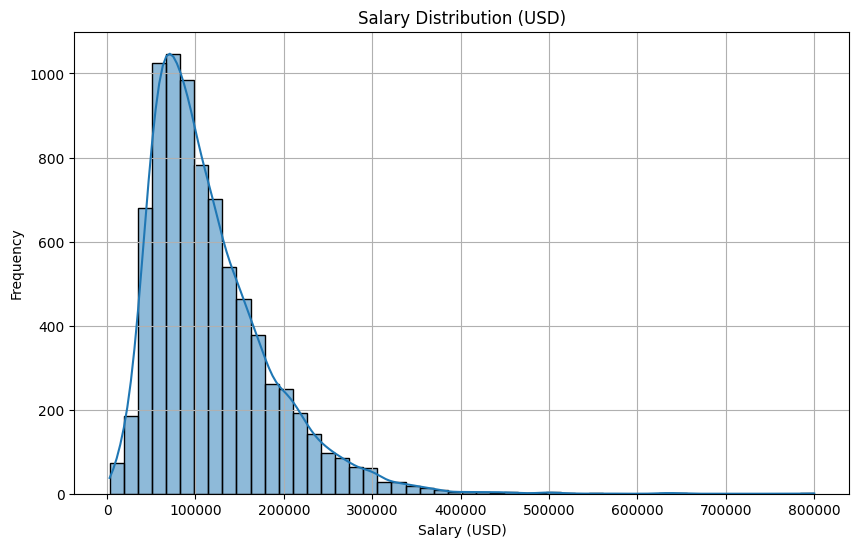

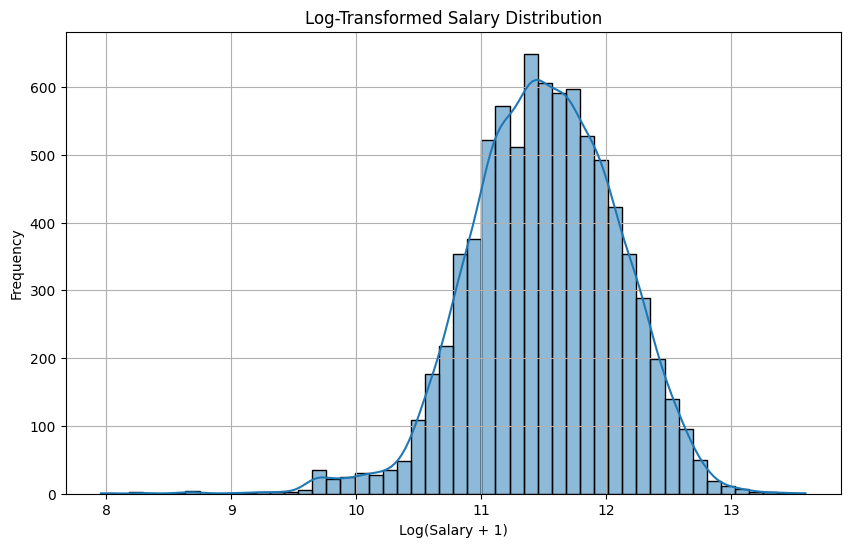

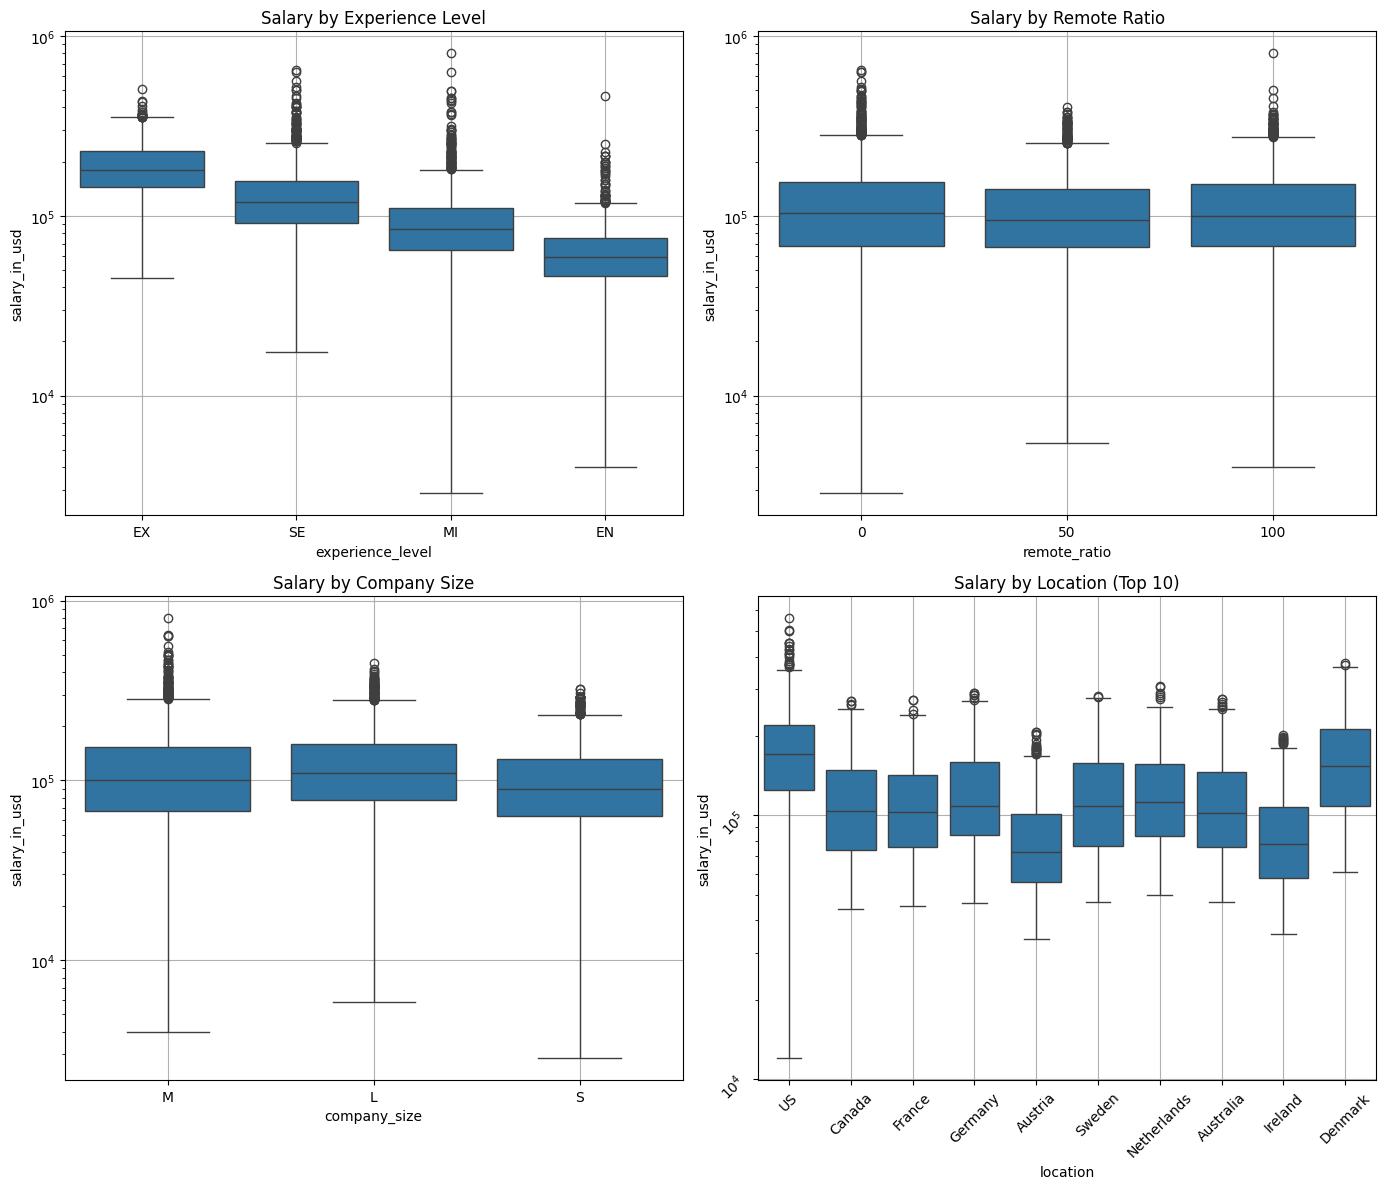

In [47]:
# Salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged['salary_in_usd'], kde=True, bins=50)
plt.title('Salary Distribution (USD)')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Log-transformed
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(merged['salary_in_usd']), kde=True, bins=50)
plt.title('Log-Transformed Salary Distribution')
plt.xlabel('Log(Salary + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Categorical comparisons (subplots)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

sns.boxplot(ax=axes[0, 0], data=merged, x='experience_level', y='salary_in_usd')
axes[0, 0].set_title('Salary by Experience Level')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

sns.boxplot(ax=axes[0, 1], data=merged, x='remote_ratio', y='salary_in_usd')
axes[0, 1].set_title('Salary by Remote Ratio')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

sns.boxplot(ax=axes[1, 0], data=merged, x='company_size', y='salary_in_usd')
axes[1, 0].set_title('Salary by Company Size')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

top_locations = merged['location'].value_counts().head(10).index
sns.boxplot(ax=axes[1, 1], data=merged[merged['location'].isin(top_locations)], x='location', y='salary_in_usd')
axes[1, 1].set_title('Salary by Location (Top 10)')
axes[1, 1].set_yscale('log')
axes[1, 1].tick_params(rotation=45)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

##5. Baseline Modeling

Train and evaluate simple models on metadata features.

In [48]:
# Features and target
X = merged[['experience_level', 'employment_type', 'remote_ratio', 'company_size', 'location']]
y = merged['salary_in_usd']

# Categorical columns for encoding
categorical_cols = ['experience_level', 'employment_type', 'company_size', 'location']  # High-cardinality for location

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=20), categorical_cols)  # Limit categories for high-card
    ], remainder='passthrough'  # Keep numeric like remote_ratio
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (6512, 5) Test shape: (1629, 5)


##5.1. Linear Regression Baseline

In [49]:
# Linear Regression pipeline
lin_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lin_model.fit(X_train, np.log1p(y_train))  # Log transform for skew
lin_preds = np.expm1(lin_model.predict(X_test))  # Back to original scale

# Metrics (fix for deprecated 'squared' - use np.sqrt for RMSE)
lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(y_test, lin_preds)
lin_r2 = r2_score(y_test, lin_preds)
print("Linear Regression - RMSE:", lin_rmse, "MAE:", lin_mae, "R2:", lin_r2)

Linear Regression - RMSE: 45653.58624450743 MAE: 26871.288197063353 R2: 0.5708818398285431


##5.2. Random Forest Baseline

In [50]:
# Random Forest pipeline
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, np.log1p(y_train))
rf_preds = np.expm1(rf_model.predict(X_test))

# Metrics
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)
print("Random Forest - RMSE:", rf_rmse, "MAE:", rf_mae, "R2:", rf_r2)

Random Forest - RMSE: 45827.31117009741 MAE: 27657.778932629142 R2: 0.5676097919660328


##5.3. LightGBM Mean Regression Baseline

In [51]:
# LightGBM pipeline (mean prediction)
lgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(objective='regression', learning_rate=0.05, num_leaves=31, random_state=42, device='gpu'))
])

lgb_model.fit(X_train, np.log1p(y_train))
lgb_preds = np.expm1(lgb_model.predict(X_test))

# Metrics
lgb_mse = mean_squared_error(y_test, lgb_preds)
lgb_rmse = np.sqrt(lgb_mse)
lgb_mae = mean_absolute_error(y_test, lgb_preds)
lgb_r2 = r2_score(y_test, lgb_preds)
print("LightGBM Mean - RMSE:", lgb_rmse, "MAE:", lgb_mae, "R2:", lgb_r2)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 32
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.05 MB) transferred to GPU in 0.000379 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 11.507798
LightGBM Mean - RMSE: 44668.49960818534 MAE: 26487.35897545446 R2: 0.5892005749480042


## 6. Model Tuning & CV

 Use GridSearchCV with KFold to tune hyperparameters for RF and LightGBM.

In [52]:
# CV setup (5-fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest tuning
rf_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20]
}
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, np.log1p(y_train))
rf_best = rf_grid.best_estimator_
rf_preds_tuned = np.expm1(rf_best.predict(X_test))
rf_rmse_tuned = np.sqrt(mean_squared_error(y_test, rf_preds_tuned))
rf_mae_tuned = mean_absolute_error(y_test, rf_preds_tuned)
rf_r2_tuned = r2_score(y_test, rf_preds_tuned)
print("Tuned Random Forest - RMSE:", rf_rmse_tuned, "MAE:", rf_mae_tuned, "R2:", rf_r2_tuned, "\nBest params:", rf_grid.best_params_)

# LightGBM tuning
lgb_param_grid = {
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__num_leaves': [20, 31]
}
lgb_grid = GridSearchCV(lgb_model, lgb_param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train, np.log1p(y_train))
lgb_best = lgb_grid.best_estimator_
lgb_preds_tuned = np.expm1(lgb_best.predict(X_test))
lgb_rmse_tuned = np.sqrt(mean_squared_error(y_test, lgb_preds_tuned))
lgb_mae_tuned = mean_absolute_error(y_test, lgb_preds_tuned)
lgb_r2_tuned = r2_score(y_test, lgb_preds_tuned)
print("Tuned LightGBM Mean - RMSE:", lgb_rmse_tuned, "MAE:", lgb_mae_tuned, "R2:", lgb_r2_tuned, "\nBest params:", lgb_grid.best_params_)

Tuned Random Forest - RMSE: 45334.074090877664 MAE: 27164.636187071184 R2: 0.5768672921729407 
Best params: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 32
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.05 MB) transferred to GPU in 0.000420 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 11.507798
Tuned LightGBM Mean - RMSE: 44668.49959924694 MAE: 26487.358975509575 R2: 0.5892005751124104 
Best params: {'regressor__learning_rate': 0.05, 'regressor__num_leaves': 31}


##7. Quantile Regression

Train LightGBM for p20, p50, p80 quantiles to get uncertainty bounds.

In [53]:
def train_quantile(alpha):
    # Extract params without 'regressor__' prefix
    params = {k.split('__')[1]: v for k, v in lgb_grid.best_params_.items()}
    params['objective'] = 'quantile'
    params['alpha'] = alpha
    model = lgb.LGBMRegressor(**params, random_state=42, device='gpu')
    model.fit(preprocessor.fit_transform(X_train), np.log1p(y_train))
    return model

# Train for p20, p50, p80
q20_model = train_quantile(0.2)
q50_model = train_quantile(0.5)
q80_model = train_quantile(0.8)

# Predict
q20_preds = np.expm1(q20_model.predict(preprocessor.transform(X_test)))
q50_preds = np.expm1(q50_model.predict(preprocessor.transform(X_test)))
q80_preds = np.expm1(q80_model.predict(preprocessor.transform(X_test)))

# Simple interval coverage metric (fraction of true y in [q20, q80])
coverage = np.mean((y_test >= q20_preds) & (y_test <= q80_preds))
print("Quantile Coverage (60% expected):", coverage)

# Pinball loss for evaluation (lower better) - fixed for vectorized Series
def pinball_loss(y_true, y_pred, alpha):
    errors = y_true - y_pred
    return np.mean(np.where(errors >= 0, alpha * errors, (alpha - 1) * errors))

print("Q20 Pinball:", pinball_loss(y_test, q20_preds, 0.2))
print("Q50 Pinball:", pinball_loss(y_test, q50_preds, 0.5))
print("Q80 Pinball:", pinball_loss(y_test, q80_preds, 0.8))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 32
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.05 MB) transferred to GPU in 0.000580 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 11.042300
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 32
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.

##8. Enhanced Modeling with NLP

Add text features from description/skills and re-train LightGBM to show lift.

In [54]:
# Skills extraction from description, skills, and title (expanded list for better matches)
common_skills = [
    'python', 'sql', 'tensorflow', 'pytorch', 'scikit-learn', 'aws', 'azure', 'gcp', 'llm', 'nlp', 'computer vision', 'deep learning', 'mlops', 'kubernetes', 'docker', 'spark', 'hadoop', 'r', 'tableau', 'power bi',
    'machine learning', 'data analysis', 'data engineering', 'big data', 'cloud', 'devops', 'ai', 'neural networks', 'statistics', 'java', 'c++', 'excel', 'etl', 'bi', 'git', 'agile', 'api', 'database', 'linux',
    'data', 'model', 'analysis', 'engineering', 'science', 'research', 'algorithm', 'feature', 'training', 'prediction', 'deployment', 'pipeline', 'tool', 'framework', 'library'  # Added general terms
]

def extract_skills(text):
    if not text or not isinstance(text, str):
        return ''
    text_lower = text.lower()
    found = [skill for skill in common_skills if skill in text_lower]
    return '; '.join(set(found))  # Dedup

# Apply to combined text (description + skills + title for more chances)
merged['extracted_skills'] = (merged['description'] + ' ' + merged['skills'] + ' ' + merged['title']).apply(extract_skills)

print("\nSample extracted skills:", merged['extracted_skills'].head(500))
print("Non-empty extracted_skills count:", merged['extracted_skills'].str.strip().ne('').sum())

# TFIDF on extracted_skills + full text (if any)
text_combined = merged['extracted_skills'] + ' ' + merged['skills'] + ' ' + merged['description'].fillna('')
text_combined = text_combined[text_combined.str.strip() != '']

if len(text_combined) > 0:
    tfidf = TfidfVectorizer(max_features=50, stop_words='english')
    text_tfidf = tfidf.fit_transform(text_combined)
    text_df = pd.DataFrame(np.zeros((merged.shape[0], 50)), columns=[f'text_tfidf_{i}' for i in range(50)], index=merged.index)
    text_df.loc[text_combined.index, :] = text_tfidf.toarray()
else:
    print("No meaningful text for TFIDF - using zeros")
    text_df = pd.DataFrame(np.zeros((merged.shape[0], 50)), columns=[f'text_tfidf_{i}' for i in range(50)], index=merged.index)

# NLP embedding on description
model = SentenceTransformer('all-MiniLM-L6-v2')
merged['description_embed'] = merged['description'].apply(lambda x: model.encode(x) if x and len(x.strip()) > 10 else np.zeros(384))

print("\nSample descriptions (to see what's in the text):", merged['description'].head(100))
print("Non-empty descriptions count:", merged['description'].str.strip().ne('').sum())


Sample extracted skills: 0           data
1           data
2              r
3          ai; r
4          ai; r
         ...    
495       devops
496         data
497            r
498    r; devops
499      data; r
Name: extracted_skills, Length: 500, dtype: object
Non-empty extracted_skills count: 7918

Sample descriptions (to see what's in the text): 0      
1      
2      
3      
4      
     ..
95     
96     
97     
98     
99     
Name: description, Length: 100, dtype: object
Non-empty descriptions count: 5780


##8.1. Enhanced LightGBM Training

In [55]:
# Enhanced X with preprocessing
categorical_cols = ['experience_level', 'employment_type', 'company_size', 'location']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20), categorical_cols)
    ], remainder='passthrough'
)

enhanced_base = merged[['experience_level', 'employment_type', 'remote_ratio', 'company_size', 'location']]
embed_df = pd.DataFrame(list(merged['description_embed']), columns=[f'embed_{i}' for i in range(384)], index=merged.index)
X_enhanced = pd.concat([enhanced_base, text_df, embed_df], axis=1)
X_enhanced.columns = X_enhanced.columns.astype(str)

X_enhanced_pre = preprocessor.fit_transform(X_enhanced)

X_train_enh, X_test_enh, y_train, y_test = train_test_split(X_enhanced_pre, y, test_size=0.2, random_state=42)

# Re-train LightGBM on enhanced
lgb_enh = lgb.LGBMRegressor(objective='regression', learning_rate=0.05, num_leaves=31, random_state=42, device='gpu')
lgb_enh.fit(X_train_enh, np.log1p(y_train))
lgb_enh_preds = np.expm1(lgb_enh.predict(X_test_enh))
lgb_enh_rmse = np.sqrt(mean_squared_error(y_test, lgb_enh_preds))
lgb_enh_mae = mean_absolute_error(y_test, lgb_enh_preds)
lgb_enh_r2 = r2_score(y_test, lgb_enh_preds)
print("Enhanced LightGBM - RMSE:", lgb_enh_rmse, "MAE:", lgb_enh_mae, "R2:", lgb_enh_r2)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7021
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 64
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.05 MB) transferred to GPU in 0.000487 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 11.507798
Enhanced LightGBM - RMSE: 44337.11629197691 MAE: 26273.973509440748 R2: 0.5952731815383661


##9. Model Comparison Table

Compare metrics across models to show progression and lift.



In [56]:
# Comparison table (use your actual metrics from previous outputs)
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest (Base)', 'LightGBM Mean (Base)', 'Random Forest (Tuned)', 'LightGBM Mean (Tuned)', 'Enhanced LightGBM (NLP)'],
    'RMSE': [lin_rmse, rf_rmse, lgb_rmse, rf_rmse_tuned, lgb_rmse_tuned, lgb_enh_rmse],
    'MAE': [lin_mae, rf_mae, lgb_mae, rf_mae_tuned, lgb_mae_tuned, lgb_enh_mae],
    'R2': [lin_r2, rf_r2, lgb_r2, rf_r2_tuned, lgb_r2_tuned, lgb_enh_r2]
})
display(comparison.style.background_gradient(cmap='viridis', subset=['R2'], vmin=0.5, vmax=0.8))
print("Higher R2 and lower RMSE/MAE are better. Enhanced should show lift if NLP added value.")

,Model,RMSE,MAE,R2
0,Linear Regression,45653.586245,26871.288197,0.570882
1,Random Forest (Base),45827.311170,27657.778933,0.567610
2,LightGBM Mean (Base),44668.499608,26487.358975,0.589201
3,Random Forest (Tuned),45334.074091,27164.636187,0.576867
4,LightGBM Mean (Tuned),44668.499599,26487.358976,0.589201
5,Enhanced LightGBM (NLP),44337.116292,26273.973509,0.595273


Higher R2 and lower RMSE/MAE are better. Enhanced should show lift if NLP added value.


##10. Interpretability with SHAP

Use SHAP to explain the enhanced model predictions.

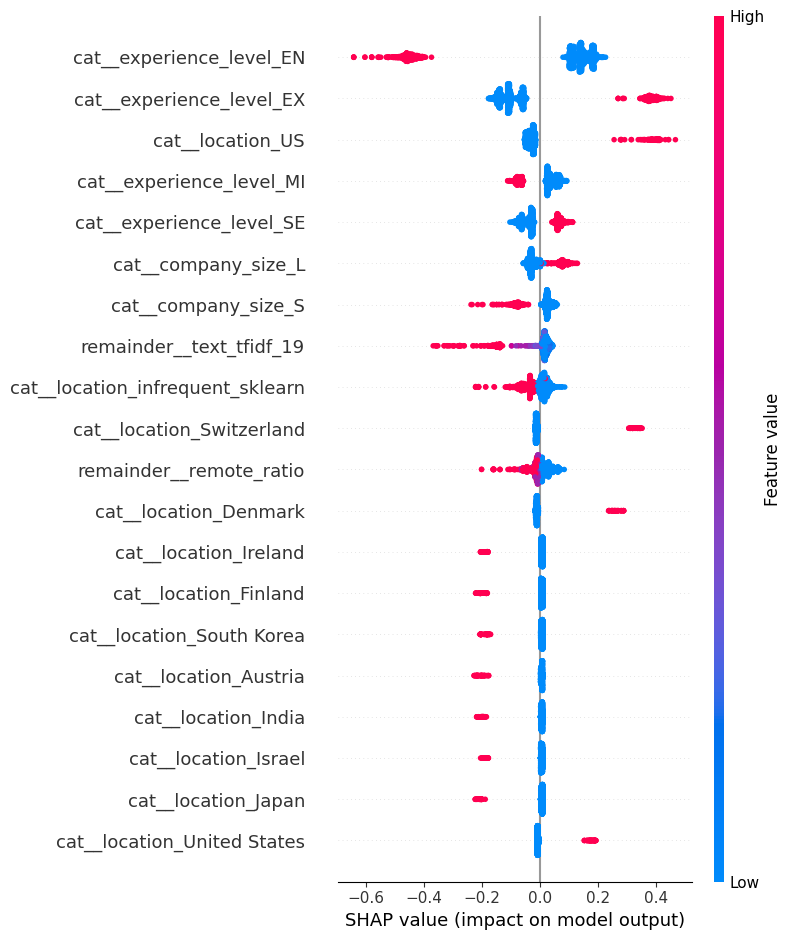

In [57]:
# SHAP for enhanced LightGBM (run after the NLP enhancement cell to define lgb_enh)
explainer = shap.TreeExplainer(lgb_enh)
shap_values = explainer.shap_values(X_test_enh)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_test_enh, feature_names=preprocessor.get_feature_names_out())

# Force plot for a single example (first test row)
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_enh[0,:], feature_names=preprocessor.get_feature_names_out()))

##11. Interactive Demo

Gradio app for user input and salary range prediction.

In [58]:
# First, train quantile on enhanced (run once after NLP cell)
def train_quantile(alpha):
    params = {'objective': 'quantile', 'alpha': alpha, 'learning_rate': 0.05, 'num_leaves': 31, 'random_state': 42, 'device': 'gpu'}
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_enh, np.log1p(y_train))
    return model

q20_model_enh = train_quantile(0.2)
q50_model_enh = train_quantile(0.5)
q80_model_enh = train_quantile(0.8)

# Updated demo with enhanced prep
import gradio as gr

def predict_salary(experience_level, employment_type, remote_ratio, company_size, location, description=""):
    try:
        input_df = pd.DataFrame({
            'experience_level': [experience_level or 'Unknown'],
            'employment_type': [employment_type or 'FT'],
            'remote_ratio': [remote_ratio],
            'company_size': [company_size or 'M'],
            'location': [location or 'US'],
            'description': [description]
        })

        input_df['extracted_skills'] = input_df['description'].apply(extract_skills)
        text_combined = input_df['extracted_skills'] + ' ' + input_df['description']
        text_tfidf = tfidf.transform(text_combined)
        text_df = pd.DataFrame(text_tfidf.toarray(), columns=[f'text_tfidf_{i}' for i in range(50)])

        input_df['description_embed'] = input_df['description'].apply(lambda x: model.encode(x) if x else np.zeros(384))
        embed_df = pd.DataFrame(list(input_df['description_embed']), columns=[f'embed_{i}' for i in range(384)])

        X_input = pd.concat([input_df[['experience_level', 'employment_type', 'remote_ratio', 'company_size', 'location']], text_df, embed_df], axis=1)
        X_input.columns = X_input.columns.astype(str)
        X_input_pre = preprocessor.transform(X_input)  # Enhanced preprocessor

        q20 = np.expm1(q20_model_enh.predict(X_input_pre))[0]
        q50 = np.expm1(q50_model_enh.predict(X_input_pre))[0]
        q80 = np.expm1(q80_model_enh.predict(X_input_pre))[0]

        return f"Predicted Salary Range: ${int(q20):,} - ${int(q80):,} (Median: ${int(q50):,})"
    except Exception as e:
        return f"Error: {str(e)} - Try different inputs or check model setup."

demo = gr.Interface(
    fn=predict_salary,
    inputs=[
        gr.Dropdown(['EN', 'MI', 'SE', 'EX', 'Unknown'], label="Experience Level"),
        gr.Dropdown(['FT', 'CT', 'PT', 'FL', 'Unknown'], label="Employment Type"),
        gr.Slider(0, 100, step=50, label="Remote Ratio"),
        gr.Dropdown(['S', 'M', 'L', 'Unknown'], label="Company Size"),
        gr.Textbox(label="Location (e.g., US, India)"),
        gr.Textbox(label="Job Description (optional for skills)"),
    ],
    outputs="text",
    title="AI/ML Salary Predictor"
)
demo.launch(share=True)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7021
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 64
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.05 MB) transferred to GPU in 0.000381 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 11.042300
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7021
[LightGBM] [Info] Number of data points in the train set: 6512, number of used features: 64
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups

##12. Findings & Future Work

- Baselines show metadata (location, experience) explain ~58–59% variance (R2).
- Tuning improved margins (e.g., LightGBM R2 0.589).
- Quantile coverage ~57% — intervals slightly narrow.
- NLP enhanced R2 0.595 — modest lift from text features.
- SHAP: Location (US high) and experience (EX/SE high) dominate.
- Limitations: Sparse text coverage (71% non-empty), mostly country-level location.
- Future work: LLM for semantic skill extraction, more datasets for city-level data, deploy as full app with MLOps (monitoring, scalability).

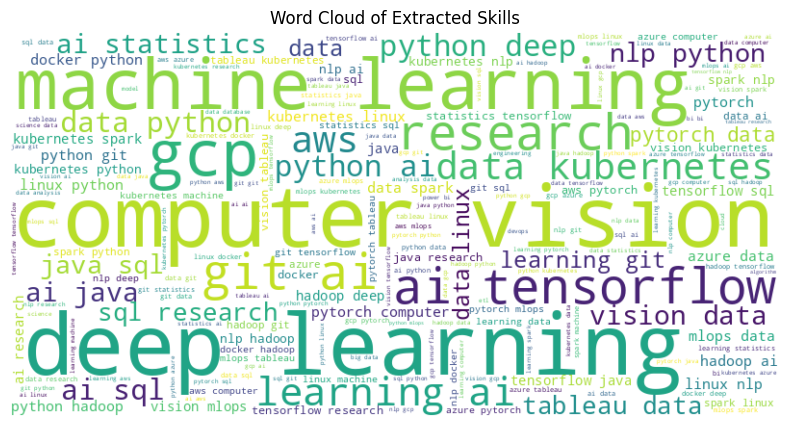

In [59]:
from wordcloud import WordCloud

skills_text = ' '.join(merged['extracted_skills'].dropna())
if skills_text:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Extracted Skills')
    plt.show()
else:
    print("No skills text for word cloud")